# Задача 3.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score, roc_auc_score, recall_score, balanced_accuracy_score, classification_report
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

rand_state = 2023

In [2]:
cwd = os.getcwd()
df = pd.read_csv(cwd+'/appl_score_sample.csv', sep=';', index_col = "CLIENT_ID")

## EDA

In [3]:
df

,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target
CLIENT_ID,,,,,,,,,,,,,
1,1,0,1,0,1,14370.2002,14370.2002,0.0,0,26,3,1,1
2,1,1,1,0,0,28312.8594,33312.8594,0.0,1,19,3,2,1
3,1,0,0,0,1,34729.5117,34729.5117,0.0,0,66,3,0,1
4,0,0,0,0,0,28738.4707,28738.4707,0.0,0,20,3,0,1
5,0,1,0,0,0,73310.0000,73310.0000,0.0,0,25,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,1,0,0,0,0,12006.0000,12000.0000,0.0,0,8,3,0,0
2159,1,1,1,1,0,0.0000,25000.0000,0.0,0,0,6,0,0
2160,1,0,0,0,0,6500.0000,6500.0000,0.0,0,12,4,0,0


In [4]:
df[df.index.duplicated(keep=False)]

,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target
CLIENT_ID,,,,,,,,,,,,,
2093,1,1,0,0,0,25453.1191,30453.1191,5000.0,0,35,5,0,0
2093,1,1,0,0,0,25453.1191,30453.1191,5000.0,0,35,5,0,1


In [5]:
# Убираем дубликаты индесов
df = df[~df.index.duplicated(keep='first')]

In [6]:
print("Число пропусков:", df.isna().sum().sum(),"\n", "Размер:", df.shape)
df.describe()

Число пропусков: 0 
 Размер: (2162, 13)


,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2.162000e+03,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.492137,0.516189,0.491674,0.094357,0.243293,20562.031529,3.914913e+04,4280.579867,0.152636,49.848289,4.354764,0.230342,0.500000
std,0.500054,0.501702,0.500046,0.292392,0.429170,31227.851310,8.472995e+04,13972.508276,0.359720,58.123567,1.166574,0.471928,0.500116
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,-3.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,7712.012675,1.615768e+04,0.000000,0.000000,13.000000,3.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,13483.279800,2.682938e+04,0.000000,0.000000,31.000000,5.000000,0.000000,0.500000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,23183.625025,4.199750e+04,3300.000000,0.000000,60.000000,5.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,707600.000000,2.699217e+06,300000.000000,1.000000,397.000000,7.000000,3.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2162 entries, 1 to 2162
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEX                      2162 non-null   int64  
 1   CHILD_FLAG               2162 non-null   int64  
 2   REALTY_FLAG              2162 non-null   int64  
 3   ACCOUNTS_FLAG            2162 non-null   int64  
 4   E_MAIL_FLAG              2162 non-null   int64  
 5   DCI                      2162 non-null   float64
 6   PROFIT_FAMILY            2162 non-null   float64
 7   UCI                      2162 non-null   float64
 8   FOREIGN_PASSPORT_FLAG    2162 non-null   int64  
 9   STANDING_IN_MONTHS_LAST  2162 non-null   int64  
 10  EDUCATION                2162 non-null   int64  
 11  TRANSPORT_AMOUNT         2162 non-null   int64  
 12  Target                   2162 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 236.5 KB


In [8]:
# Все фитчи имеют не нулевой std, тип данных - числовой и категориальный, нет дат
selector = VarianceThreshold(threshold=0.0)
pd.DataFrame(columns = df.columns, data = selector.fit_transform(df)).shape

(2162, 13)

In [9]:
# Дисбаланса классов нет
df.Target.value_counts()

1    1081
0    1081
Name: Target, dtype: int64

### Outliers
Вцелом глянем на данные. Видим аутлаеры - удалим их с помощью LocalOutlierFactor

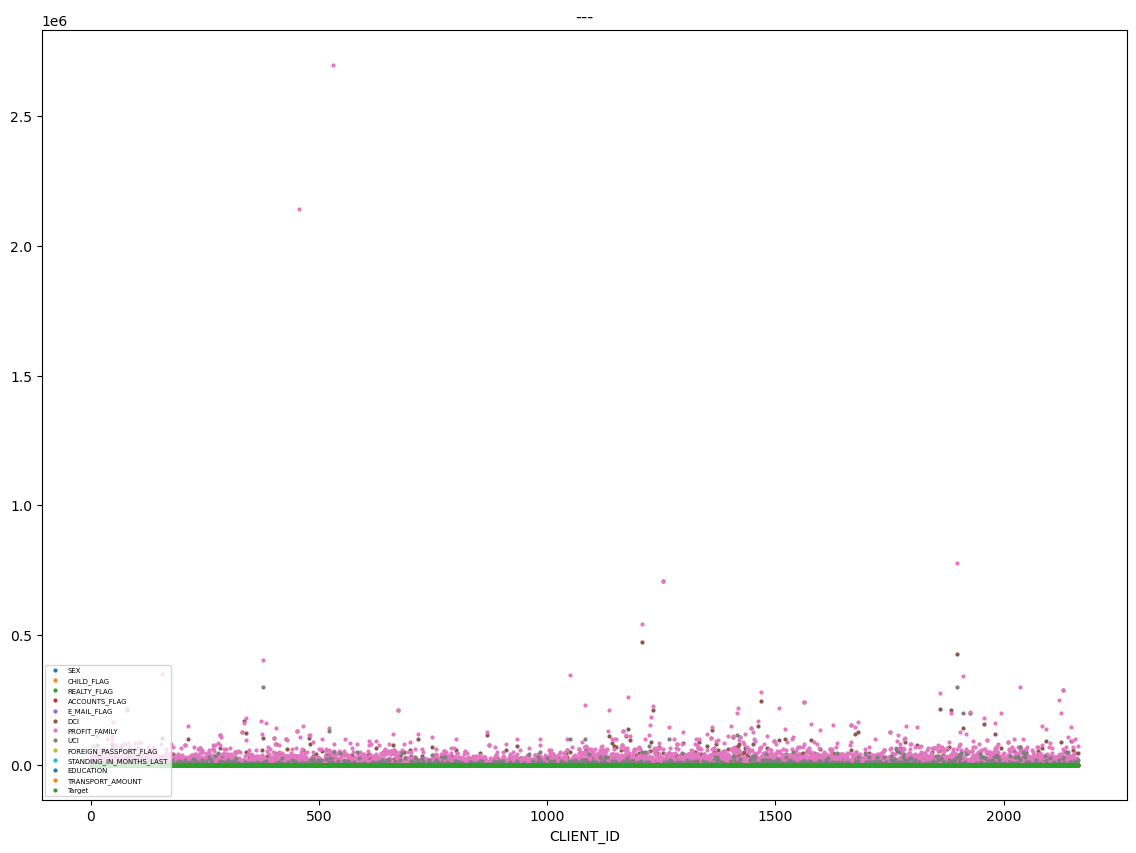

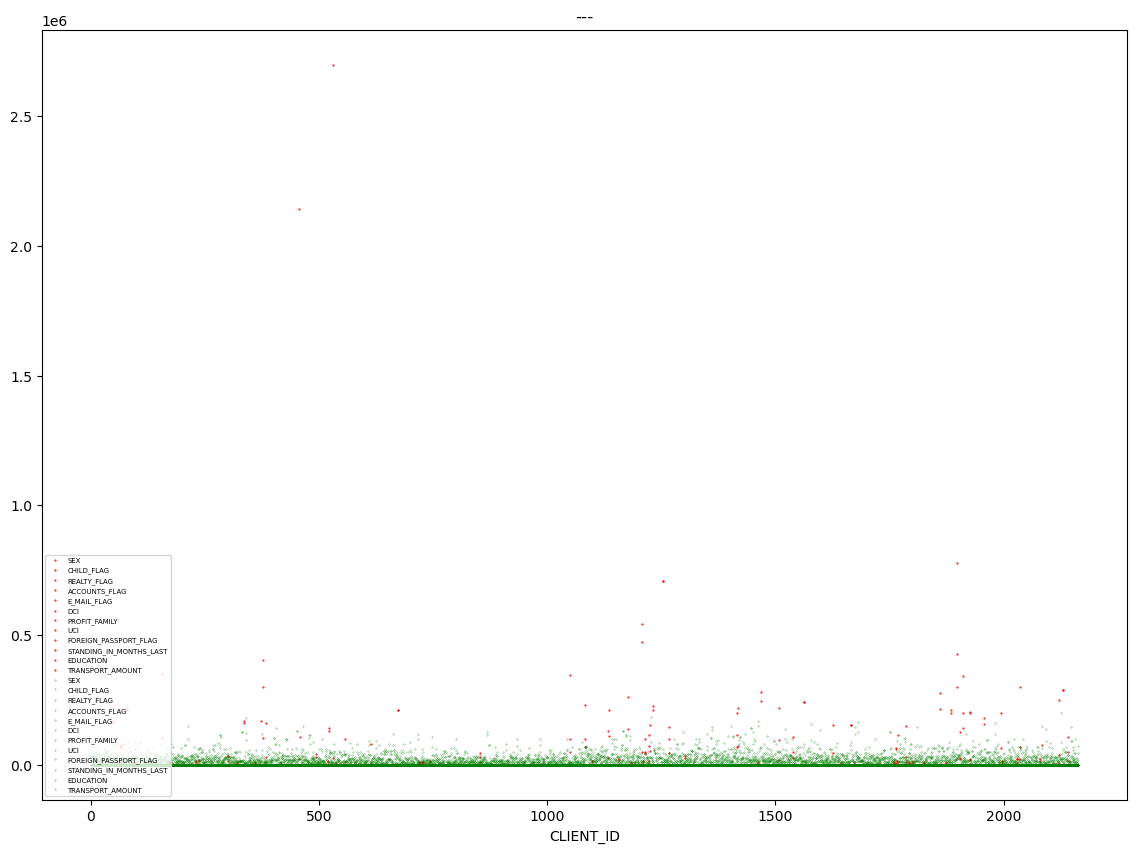

(2072, 12) (2162, 13)


In [10]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
df.plot(marker='o', markersize=2, linestyle = 'None', ax=ax)
plt.legend(loc ="lower left", fontsize=5)
plt.title('---'), plt.show();

X = df.drop(['Target'], axis = 1)
clf = LocalOutlierFactor(n_neighbors=50, algorithm='auto', metric='minkowski', contamination='auto', n_jobs=-1) # -1 outlier, 1 good
pred = clf.fit_predict(X)
X['outlier'] = pred

fig, ax = plt.subplots(1,1, figsize=(14,10))
X.drop(columns=['outlier'])[X.outlier==-1].plot(marker='o', markersize=0.5, linestyle = 'None', ax=ax, c='r')
X.drop(columns=['outlier'])[X.outlier== 1].plot(marker='o', markersize=0.2, linestyle = 'None', ax=ax, c='g')
plt.legend(loc ="lower left", fontsize=5)
plt.title('---'), plt.show()

X = X[X['outlier']==1].drop(columns=['outlier'])

del pred
print(X.shape, df.shape)

### OneHotEncoder
Для колонки education применим энкодинг с объединением на группы - такой подход внесет доп инфу для модели, увеличит точность, уменьшит вероятность переобучения

EDUCATION

1 - ученая степень/MBA

2 - второе высшее

3 - высшее;

4 - неоконченное высшее;

5 - - среднее специальное

6 - среднее;

7 - ниже среднего;

 -1 - не указано

In [11]:
df['EDUCATION'].value_counts()

5    810
3    678
6    353
4    264
2     40
7     10
1      7
Name: EDUCATION, dtype: int64

In [12]:
def encode_and_bind(original_dataframe: pd.DataFrame, feature_to_encode: 'str'):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1).drop([feature_to_encode], axis = 1)
    return(res)

In [13]:
encode_and_bind(X, 'EDUCATION')

,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,TRANSPORT_AMOUNT,1,2,3,4,5,6,7
CLIENT_ID,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,14370.2002,14370.2002,0.0,0,26,1,0,0,1,0,0,0,0
2,1,1,1,0,0,28312.8594,33312.8594,0.0,1,19,2,0,0,1,0,0,0,0
3,1,0,0,0,1,34729.5117,34729.5117,0.0,0,66,0,0,0,1,0,0,0,0
4,0,0,0,0,0,28738.4707,28738.4707,0.0,0,20,0,0,0,1,0,0,0,0
5,0,1,0,0,0,73310.0000,73310.0000,0.0,0,25,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,1,0,0,0,0,12006.0000,12000.0000,0.0,0,8,0,0,0,1,0,0,0,0
2159,1,1,1,1,0,0.0000,25000.0000,0.0,0,0,0,0,0,0,0,0,1,0
2160,1,0,0,0,0,6500.0000,6500.0000,0.0,0,12,0,0,0,0,1,0,0,0


In [14]:
X = encode_and_bind(X, 'EDUCATION')
X['1-2-3'] = X[1]+X[2]+X[3]
X['4-5-6'] = X[4]+X[5]+X[6]
X['7--1'] = X[7] # -1 категоий нет
X = X.drop([1,2,3,4,5,6,7], axis = 1)

## ML

Есть целессобразность использовать 2 метода:
- logistic regression
- random forest

Для набора данных ~2000 применять бутинги (нужно >10^4) и DL нет целесообразности.
В данной задаче, в силу большого колличества категориальных фитчей выбор в пользу random forest.
Фитчей не так много, поэтому feature selection не применялся

В качестве главной метрики выберем ROC AUC - отображает истинную и постоянную способность модели к прогнозированию (если я изменю тестовый набор данных)

In [15]:
y = pd.merge(X, df["Target"], how = 'left', on = 'CLIENT_ID')[['Target']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_state, shuffle=True, stratify=y)

In [17]:
print("Соотношение классов в train и test соответственно: ", len(y_train[y_train == 1])/len(y_train), ";", len(y_test[y_test == 1])/len(y_test))

Соотношение классов в train и test соответственно:  1.0 ; 1.0


In [25]:
hyperparam_grid = { 
    'n_estimators': [100, 200, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    # 'min_samples_split' : [2, 5],
    # 'min_samples_leaf' : [1, 2, 4],
    'criterion' :['gini', 'entropy'],
}

In [26]:
%%time
clf = RandomForestClassifier(random_state = rand_state)
grid = GridSearchCV(clf, hyperparam_grid, scoring="roc_auc", cv=4, n_jobs=-1)
grid.fit(X_train, y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7191613499755471 with param: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
CPU times: total: 703 ms
Wall time: 12.2 s


Accuracy Score: 0.638996138996139
Area Under Curve: 0.6388106206300224
Recall score: 0.6628352490421456


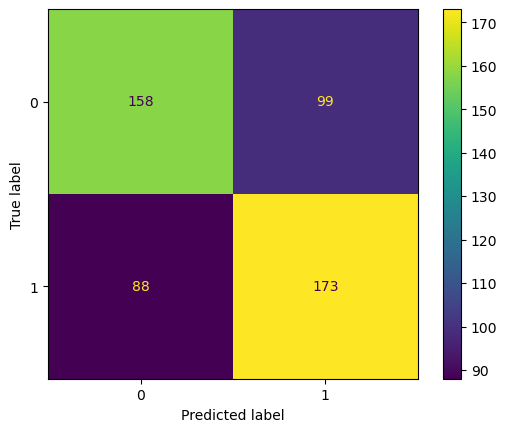

In [27]:
# performance НА тесте, 0 - negative, 1 -  positive
y_test_pred = grid.best_estimator_.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test,y_test_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_test_pred)}')
print(f'Recall score: {recall_score(y_test,y_test_pred)}')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred), display_labels=grid.classes_)
disp.plot()
plt.show()

In [28]:
print(classification_report(y_train,grid.best_estimator_.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       770
           1       0.67      0.73      0.70       784

    accuracy                           0.69      1554
   macro avg       0.69      0.69      0.69      1554
weighted avg       0.69      0.69      0.69      1554



In [23]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       257
           1       0.64      0.68      0.66       261

    accuracy                           0.64       518
   macro avg       0.64      0.64      0.64       518
weighted avg       0.64      0.64      0.64       518



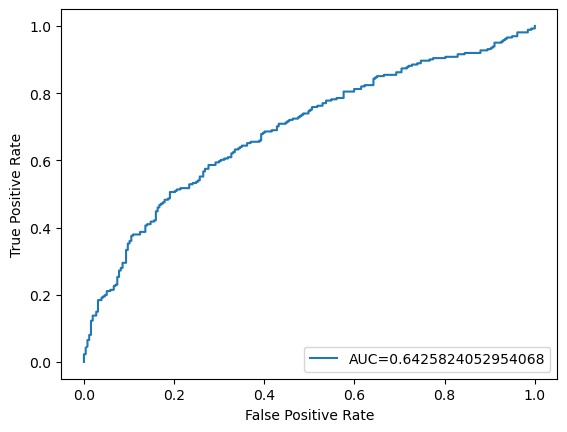

In [24]:
#ROC curve
y_pred_proba = grid.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_test_pred)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Заключение
Полученный ROC AUC на тестовой выборке ~ 0.65, accuracy ~ 0.65. Модель не переобучена, так как метрики на test и tarin схожи, а так же n_estimators грид серч выбрал самый маленький

Невысокие результаты по метрикам могут быть объяснены:

- малым размером выборки 

Что необходимо было бы опробовать для данной задачи и сравнить результаты: 

- поробовать другие модели, например лог регрессию, KNN
- "поиграть" с трешхолдом для причисления к классу
- более глубокий feature engineering and feature selection

# Задача 5.

In [105]:
#1) В dataframe с именем subset_1 сохраните только первые 20 строк и только 1 и 5 колонку.
subset_1 = df.iloc[:20, 5] # 1я колонка - это индекс
#2) В dataframe subset_2 сохраните только тех клиентов-мужчин, у которых значения переменной STANDING_IN_MONTHS_LAST строго больше 50.
subset_2 = df[df["STANDING_IN_MONTHS_LAST"]>50]

In [106]:
new_df = df.copy()
#3) Создайте две новые переменных:
# CI = DCI + UCI
# CI_ln = натуральный логарифм переменной CI.
new_df["CI"] =  new_df["DCI"]+new_df["UCI"]
new_df["CI_ln"] = np.log(new_df['CI']) 

In [107]:
#4)	Для данных рассчитайте среднее значение переменной CI для каждого типа образования (переменная EDUCATION), 
#в получившемся dataframe переменная EDUCATION не должна превратиться в индекс. Также переименуйте колонку со средним значением CI в MEAN_CI.
MEAN_CI = new_df.groupby(['EDUCATION']).mean()["CI"]
new_df['MEAN_CI'] = new_df['EDUCATION']
for i in range(len(MEAN_CI)): new_df['MEAN_CI'].replace(MEAN_CI.index[i], MEAN_CI.values[i], inplace=True)

In [108]:
#5)	В переменной TRANSPORT_AMOUNT замените все отрицательные значения на медианное значение переменной TRANSPORT_AMOUNT (без учета отрицательных значений, разумеется).
_ = new_df["TRANSPORT_AMOUNT"][new_df["TRANSPORT_AMOUNT"] >= 0].median() 
new_df["TRANSPORT_AMOUNT"][new_df["TRANSPORT_AMOUNT"] < 0] = _

In [109]:
new_df

,SEX,CHILD_FLAG,REALTY_FLAG,ACCOUNTS_FLAG,E_MAIL_FLAG,DCI,PROFIT_FAMILY,UCI,FOREIGN_PASSPORT_FLAG,STANDING_IN_MONTHS_LAST,EDUCATION,TRANSPORT_AMOUNT,Target,CI,CI_ln,MEAN_CI
CLIENT_ID,,,,,,,,,,,,,,,,
1,1,0,1,0,1,14370.2002,14370.2002,0.0,0,26,3,1,1,14370.2002,9.572912,36233.867539
2,1,1,1,0,0,28312.8594,33312.8594,0.0,1,19,3,2,1,28312.8594,10.251071,36233.867539
3,1,0,0,0,1,34729.5117,34729.5117,0.0,0,66,3,0,1,34729.5117,10.455345,36233.867539
4,0,0,0,0,0,28738.4707,28738.4707,0.0,0,20,3,0,1,28738.4707,10.265992,36233.867539
5,0,1,0,0,0,73310.0000,73310.0000,0.0,0,25,3,0,1,73310.0000,11.202452,36233.867539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,1,0,0,0,0,12006.0000,12000.0000,0.0,0,8,3,0,0,12006.0000,9.393162,36233.867539
2159,1,1,1,1,0,0.0000,25000.0000,0.0,0,0,6,0,0,0.0000,-inf,16195.841409
2160,1,0,0,0,0,6500.0000,6500.0000,0.0,0,12,4,0,0,6500.0000,8.779557,19460.352806
